In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/661.6 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 256.0/661.6 kB 7.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=d789d9607ddc5ab115eb32057a2b755d41ce1f9fb8c386e9d36a18a00918f0c9
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 885.5/885.5 kB 63.1 MB/s eta 0:00:00


In [1]:
import torch
from torch import Tensor
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch_geometric.loader import RandomNodeLoader
from torch_geometric.nn import DeepGCNLayer, GENConv, DynamicEdgeConv
from torch_geometric.utils import scatter
from torch.utils.data import DataLoader, Dataset
from torch_geometric import transforms as geometric_transforms
from torchvision import transforms
import numpy as np
from PIL import Image
import os
import pickle
from torch_geometric.datasets import KarateClub
from torch_geometric .data import Data
from torch_geometric.nn import MessagePassing
from torch_cluster import knn_graph
import torch_geometric.nn as pyG
from torch_geometric.utils import softmax
import torch_cluster
from math import sqrt
import matplotlib.pyplot as plt
hr_height = 256
hr_width = 256

In [ ]:
import gc
gc.collect()

!kill -9 -1

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
myTransforms1 = transforms.Compose([
    transforms.Resize((hr_height,hr_width))
])

myTransforms2 = transforms.Compose([
          transforms.Resize((hr_height+50,hr_width+50)),
          transforms.RandomCrop((256,256)),
          transforms.ColorJitter(brightness=0.5),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomGrayscale(),
      ])


train_path = './div2k_dataset/DIV2K_train_HR/'
files = os.listdir(train_path)
train_imgs = []

# original images
for file in files:
  img = Image.open(os.path.join(train_path,file))
  train_imgs.append(myTransforms1(img))

# agumented images
for _ in range(9):
  for file in files:
    img = Image.open(os.path.join(train_path,file))
    train_imgs.append(myTransforms2(img))

test_path = './div2k_dataset/DIV2K_valid_HR/'
files = os.listdir(test_path)
test_imgs = []
for file in files:
  img = Image.open(os.path.join(test_path,file))
  test_imgs.append(myTransforms1(img))

with open('train_imgs','wb') as fp:
  pickle.dump(train_imgs,fp)
with open('test_imgs','wb') as fp:
  pickle.dump(test_imgs,fp)

In [2]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

with open('train_imgs','rb') as fp:
  train_imgs = pickle.load(fp)
with open('test_imgs','rb') as fp:
  test_imgs = pickle.load(fp)

In [3]:
class ImageDataset(Dataset):
    def __init__(self,imgs, scale=4, m=4):
        super().__init__()

        self.files = imgs
        self.m = m

        # Transforms for low resolution images and high resolution images
        self.hr_height, self.hr_width = (256,256)

        self.hr_transform = transforms.Compose([
          transforms.Resize((hr_height,hr_width)),
          transforms.ToTensor()
      ])
        self.lr_transform = transforms.Compose([
          transforms.Resize((self.hr_height//scale,self.hr_width//scale)),
          transforms.ToTensor(),
          transforms.Normalize(mean,std)
      ])

    def __getitem__(self, index):
        img = self.files[index]
        img_hr = self.hr_transform(img)
        img_hr = img_hr*2 - 1
        img_lr = self.lr_transform(img)
        h, w = self.hr_height, self.hr_width
        hr_num = int(h*w/self.m **2)
        lr_num = hr_num // 16
        img_hr = img_hr.unfold(1,self.m,self.m).unfold(2,self.m,self.m).reshape((3,hr_num,self.m**2)).swapaxes(0,1).flatten(1,-1)
        img_lr = img_lr.unfold(1,self.m,self.m).unfold(2,self.m,self.m).reshape((3,lr_num,self.m**2)).swapaxes(0,1).flatten(1,-1)
        return (img_lr, img_hr)

    def __len__(self):
        return len(self.files)

In [4]:
scale = 4
m = 4 # hyper parameter (patch dim)
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_set = ImageDataset(train_imgs, scale, m)
test_set = ImageDataset(test_imgs, scale, m)

trainLoader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(test_set, batch_size=1, shuffle=True)

# Define Model

In [5]:
small_k = 3
large_k = 9
class MRGCN(MessagePassing):
    def __init__(self, in_channel, out_channel, d=1, k=small_k):
        super().__init__(aggr='max')
        self.d = d
        self.k = k
        self.in_channel = in_channel
        self.out_channel = out_channel

        self.mlp = nn.Sequential(nn.Linear(2*in_channel,out_channel), nn.LeakyReLU(inplace=True), nn.Linear(out_channel,out_channel))

    def reset_parameters(self):
        super().reset_parameters()
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()



    def forward(self, x:torch.Tensor):
        if self.d == 1:
            B, N, D = x.shape
            x = x.reshape(B*N,-1)
            batch = torch.repeat_interleave(torch.arange(B),N).to(device)
            edge_index = knn_graph(x=x, k=self.k, batch=batch)
            m =  self.propagate(edge_index=edge_index,x=x)
            return self.mlp(torch.cat((x,m),dim=1).reshape(B,N,-1))


        """B, N, D = x.shape
        x = x.reshape(B*N,D)
        num = self.k * self.d
        batch = torch.repeat_interleave(torch.arange(B),N).to(device)
        edge_index = knn_graph(x=x, k=num, batch=batch)
        idxs = torch.arange(0,num,self.d)
        temp = edge_index[0].reshape(-1,num)
        dilated_edge_index =   torch.stack((temp[:,idxs].flatten(),torch.Tensor.repeat_interleave(torch.arange(B*N),self.k)))
        m =  self.propagate(edge_index=dilated_edge_index,x=x)
        return self.mlp(torch.cat((x,m),dim=1).reshape(B,N,-1))"""


    def message(self, x_i, x_j) -> Tensor:
        return x_j - x_i

class batchNorm(nn.Module):
    def __init__(self, in_channels, eps=0.00001):
        super(batchNorm,self).__init__()
        self.b = nn.BatchNorm1d(in_channels,eps)
    def forward(self,x:torch.Tensor):
        B, N, D = x.shape
        x = x.swapaxes(1,2)
        x = self.b(x)
        return x.swapaxes(1,2)

class PixelShuffel(nn.Module):
    def __init__(self, in_channels):
        super(PixelShuffel,self).__init__()
        assert in_channels % 4 == 0
        self.in_channels = in_channels

    def forward(self,x:torch.Tensor):
        B, N, _ = x.shape
        w = int(sqrt(N))
        num_channels = self.in_channels // 4
        x1 = x[:,:,range(0,num_channels)].swapaxes(1,2)
        x2 = x[:,:,range(num_channels,2*num_channels)].swapaxes(1,2)
        x3 = x[:,:,range(2*num_channels,3*num_channels)].swapaxes(1,2)
        x4 = x[:,:,range(3*num_channels,4*num_channels)].swapaxes(1,2)
        return F.pixel_shuffle(torch.stack((x1,x2,x3,x4),dim=2).reshape(B,self.in_channels,w,w),upscale_factor=2).flatten(2).swapaxes(1,2)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            MRGCN(in_features, in_features, k=small_k),
            batchNorm(in_features),
            nn.PReLU(),
            MRGCN(in_features, in_features, k=small_k),
            batchNorm(in_features)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class DeepGCN(nn.Module):
    def __init__(self, in_channels=3*m**2, out_channels=3*m**2 ,n_residual_blocks=8):
        super().__init__()
        # First layer
        self.hidden_layers = 32*m**2
        # k=81
        self.conv1 = nn.Sequential(MRGCN(in_channels, self.hidden_layers, k=large_k),nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(self.hidden_layers))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(MRGCN(self.hidden_layers, self.hidden_layers, k=small_k), batchNorm(self.hidden_layers,))

        # Upsampling layers
        upsampling = []
        for _ in range(2):
            upsampling.extend([MRGCN(self.hidden_layers,4*self.hidden_layers,k=small_k),batchNorm(4*self.hidden_layers),PixelShuffel(4*self.hidden_layers),nn.PReLU()])
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        # k=81
        self.conv3 = nn.Sequential(MRGCN(self.hidden_layers, out_channels, k=large_k), nn.Tanh())

    def forward(self,x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

# Fit Model

In [8]:
learning_rate = 0.0002
epoch_nums = 5
deepGCN = DeepGCN().to(device)
criterion = nn.MSELoss().to(device)
b1 = 0.5
b2 = 0.999
optimizer = torch.optim.Adam(params=deepGCN.parameters(), lr=learning_rate, betas=(b1,b2))
batch_num = len(trainLoader)
losses = []
for epoch in range(epoch_nums):  # loop over the dataset multiple times
    deepGCN.train()
    running_loss = 0.0
    tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len(trainLoader)))

    for i, imgs in enumerate(tqdm_bar):
        ## FILL HERE
        ## You should train the model and also print the running loss for each batch
        lr, hr = imgs
        lr = lr.to(device)
        hr = hr.to(device)
        sr = deepGCN(lr)
        optimizer.zero_grad()
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    running_loss /= batch_num
    losses.append(running_loss)
    print('epoch : ',epoch,', loss : ',running_loss)
    torch.save(deepGCN.state_dict(), 'DeepGCN_model.pth')
print('Finished Training')


Training Epoch 0 : 100%|██████████| 250/250 [1:06:14<00:00, 15.90s/it]


epoch :  0 , loss :  0.07161159113049508


Training Epoch 1 : 100%|██████████| 250/250 [1:06:20<00:00, 15.92s/it]


epoch :  1 , loss :  0.031493127651512624


Training Epoch 2 : 100%|██████████| 250/250 [1:06:30<00:00, 15.96s/it]


epoch :  2 , loss :  0.025595117606222628


Training Epoch 3 : 100%|██████████| 250/250 [1:06:30<00:00, 15.96s/it]


epoch :  3 , loss :  0.02350800411403179


Training Epoch 4 : 100%|██████████| 250/250 [1:06:13<00:00, 15.89s/it]

epoch :  4 , loss :  0.030633556127548218
Finished Training


In [10]:
# save model
torch.save(deepGCN.state_dict(), 'DeepGCN_model.pth')

# Results

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load SRResNet model
deepGCN = DeepGCN().to(device) 
deepGCN.load_state_dict(torch.load('DeepGCN_model.pth'))
srres_model = deepGCN.to(device)

Text(0.5, 1.0, 'DeepGCN Network')

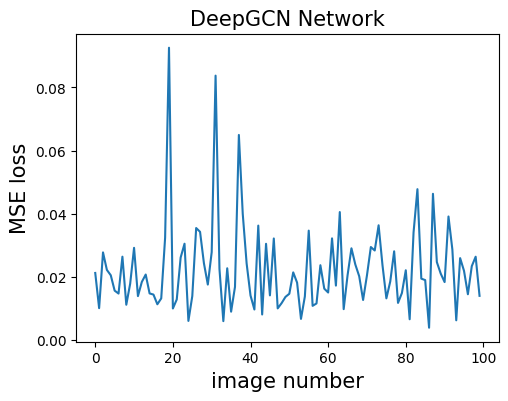

In [36]:
criterion = nn.MSELoss().to(device)

losses = []
low_res_images = []
super_res_images = []
high_res_images = []

with torch.no_grad():
    deepGCN.eval()
    for i, imgs in enumerate(testLoader):
        lr, hr = imgs
        lr = lr.to(device)
        hr = hr.to(device)
        sr = deepGCN(lr)
        loss = criterion(sr, hr)
        losses.append(loss.item())
        super_res_images.append(torch.squeeze(sr.cpu(),dim=0))
        low_res_images.append(torch.squeeze(lr.cpu(),dim=0))
        high_res_images.append(torch.squeeze(hr.cpu(),dim=0))

super_res_images = torch.stack(super_res_images,dim=0)
low_res_images = torch.stack(low_res_images,dim=0)
high_res_images = torch.stack(high_res_images,dim=0)

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(range(0,100),losses)
plt.xlabel('image number',fontsize=15)
plt.ylabel('MSE loss',fontsize=15)
plt.title('DeepGCN Network',fontsize=15)

In [37]:
def patches_to_image(patches:torch.Tensor, height, width):
    temp = patches.reshape((-1,3,16)).swapaxes(0,1).reshape(3,-1,4,4)
    image = torch.zeros((3,height,width))
    row = col = -4
    check = width // 4
    for i,patch in enumerate(temp[0,:]):
        if i % (check) == 0:
            row += 4
            col = -4
        col += 4
        image[0,row,torch.arange(col,col+4)] = patch[0,:]
        image[0,row+1,torch.arange(col,col+4)] = patch[1,:]
        image[0,row+2,torch.arange(col,col+4)] = patch[2,:]
        image[0,row+3,torch.arange(col,col+4)] = patch[3,:]

    row = col = -4
    for i,patch in enumerate(temp[1,:]):
        if i % (check) == 0:
            row += 4
            col = -4
        col += 4
        image[1,row,torch.arange(col,col+4)] = patch[0,:]
        image[1,row+1,torch.arange(col,col+4)] = patch[1,:]
        image[1,row+2,torch.arange(col,col+4)] = patch[2,:]
        image[1,row+3,torch.arange(col,col+4)] = patch[3,:]

    row = col = -4
    for i,patch in enumerate(temp[2,:]):
        if i % (check) == 0:
            row += 4
            col = -4
        col += 4
        image[2,row,torch.arange(col,col+4)] = patch[0,:]
        image[2,row+1,torch.arange(col,col+4)] = patch[1,:]
        image[2,row+2,torch.arange(col,col+4)] = patch[2,:]
        image[2,row+3,torch.arange(col,col+4)] = patch[3,:]
    return image

In [38]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

idxs = np.random.randint(0,100,10)
outputs_low = [invTrans(patches_to_image(img,hr_height//4, hr_width//4)).permute(1,2,0) for img in low_res_images[idxs,:,:]]
outputs_super = [((patches_to_image(img,hr_height,hr_width)+1)/2).permute(1,2,0) for img in super_res_images[idxs,:,:]]
outputs_high = [((patches_to_image(img,hr_height,hr_width)+1)/2).permute(1,2,0) for img in high_res_images[idxs,:,:]]

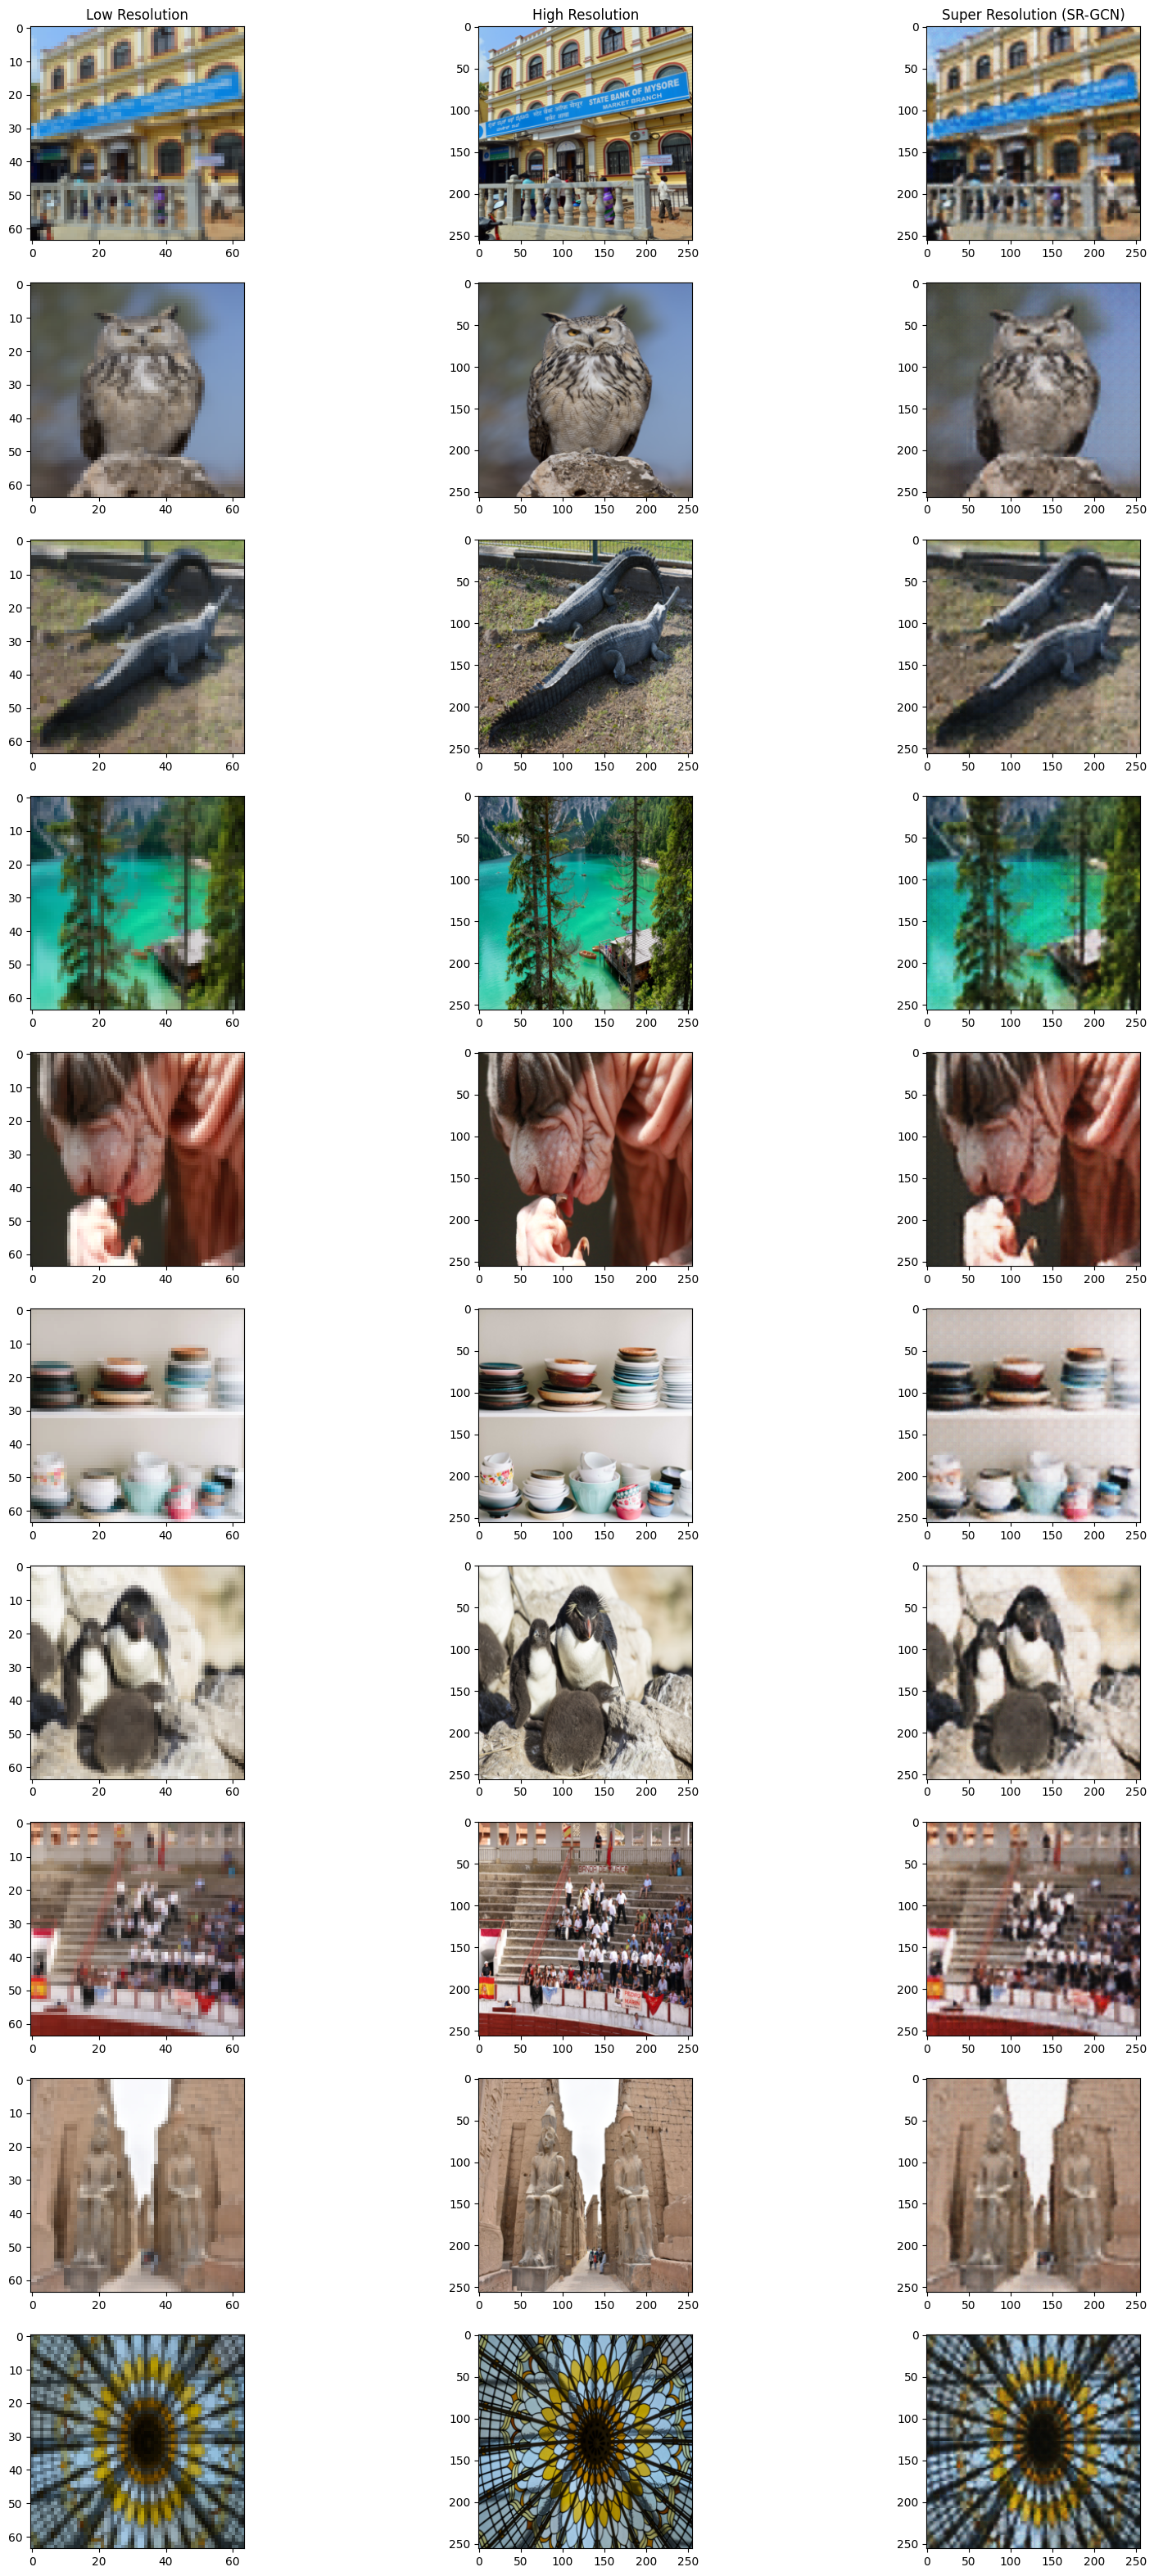

In [39]:
plt.figure(figsize=(20,40))
plt.subplot(10,3,1)
plt.imshow(outputs_low[0])
plt.title('Low Resolution')
plt.subplot(10,3,2)
plt.imshow(outputs_high[0])
plt.title('High Resolution')
plt.subplot(10,3,3)
plt.imshow(outputs_super[0])
plt.title('Super Resolution (SR-GCN)')

for i in range(1,10):
    plt.subplot(10,3,3*i+1)
    plt.imshow(outputs_low[i])
    plt.subplot(10,3,3*i+2)
    plt.imshow(outputs_high[i])
    plt.subplot(10,3,3*i+3)
    plt.imshow(outputs_super[i])

plt.show()